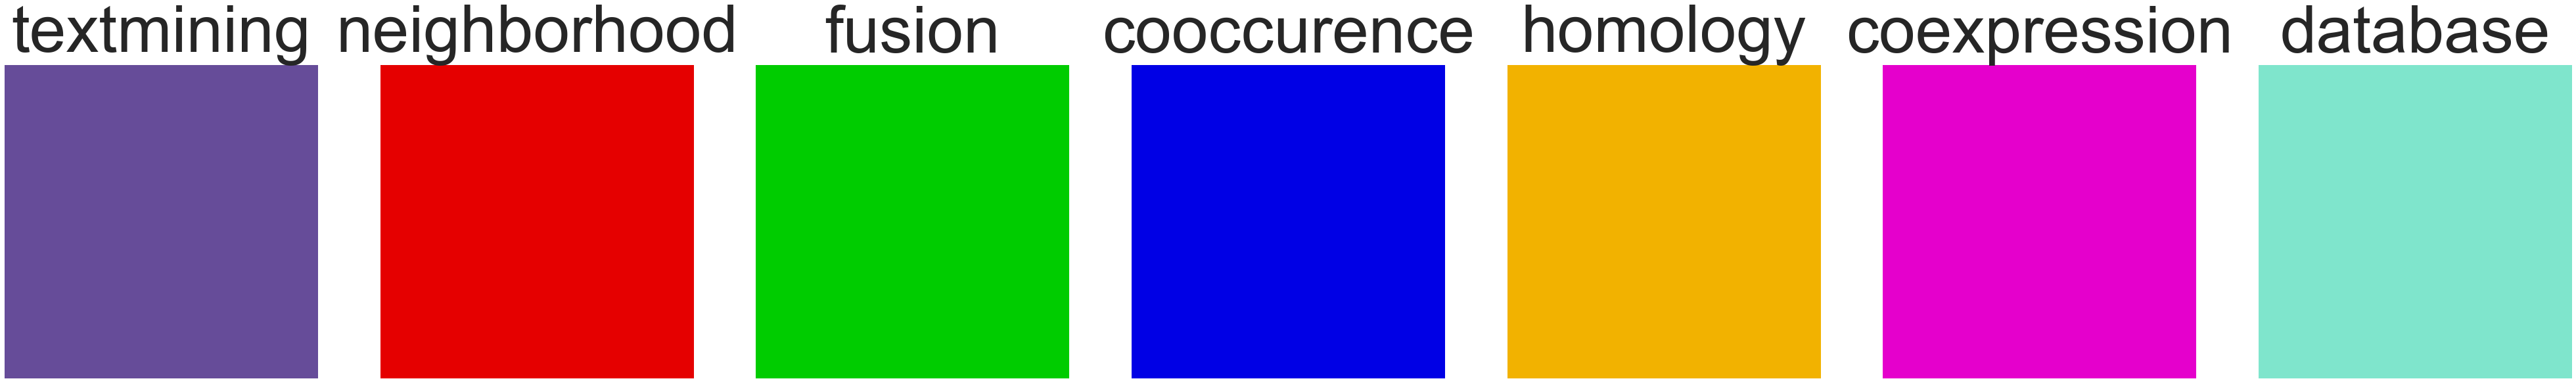

In [2]:
import os
import numpy as np
import pandas as pd
import math
from warnings import warn
from matplotlib import pyplot as plt
from scipy.spatial import distance
from scipy.signal import find_peaks
from scipy.stats import trim_mean
import math
from tqdm import tqdm
import skimage.io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian, threshold_local
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from skimage.util import invert
from skimage.measure import regionprops, label
from skimage.color import label2rgb
from skimage.draw import rectangle_perimeter
from skimage.transform import rescale, resize, downscale_local_mean
import os
import seaborn as sns
from scipy import stats
import cytoflow as flow
from skimage.transform import rotate

import pickle
#create a network linking genes in a group
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import torch
import torch.nn as nn
import torch.nn.functional as F

import plotly.graph_objects as go
import plotly.express as px
import imagecodecs

import importlib
import Colony_Analysis as ca
import GOEA as ge
import  String_Networks as sn

In [3]:
#textmining: abstracts
#neighborhood : proximity on chromosome
#fusion : looks if genes are fused in other organisms
#co-occurence: evolutionary co-occurence 
#homology
#coexpression
#database

from networkx import find_cliques,find_cliques_recursive
import re

### Parse screen data

In [4]:
#Load data
CCM16= pd.read_csv('/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/CCM18.10.22/GA16.csv', sep=',')
CCM19 =pd.read_csv('/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/CCM6.12.22/GA19.csv', sep=',')
CCM_pooled =pd.read_csv('/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/CCM6.12.22/GA16_19.csv', sep=',')
CCM20 =pd.read_csv('/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/CCM_OEx23.3.15/GA20.csv', sep=',')

# we normalize the data
DFs= [CCM20, CCM_pooled,CCM19,CCM16]
metrics = ['corrected_mean_intensity.48','corrected_area.48']

for metric in metrics:
    for DF in DFs:
        #we first correct the std using the screens mean
        #we then correct the mean
        DF[metric +'_std'] = (DF[metric+'_std'])/DF[metric+'_mean'].std()
        DF[metric +'_mean'] = (DF[metric+'_mean']-DF[metric+'_mean'].mean())/DF[metric+'_mean'].std()
        
        

### Create a "Dosage" Metric combining OEx and KO data for color visualisation

/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(0, -1.0, '3'),
 Text(0, 0.0, '2'),
 Text(0, 1.0, '1'),
 Text(0, 2.0, '0'),
 Text(0, 3.0, '-1'),
 Text(0, 4.0, '-2'),
 Text(0, 5.0, '-3'),
 Text(0, 6.0, ''),
 Text(0, 7.0, '')]

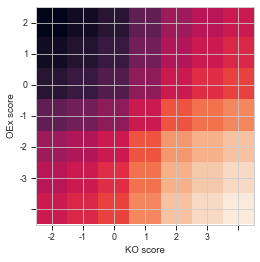

In [5]:
# we need a color code that represents both OEx and KO data
# all of this is a heuristic maping the 2D KO, OEx data to the 3D rgb space to get pretty colors

# we create a non linear function which conserves the sign of the interaction with (2*(OEx>0)-1)
# doasage is defined as the substraction sigma(OEx)-sigma(KO) where sigma() represents the non linearity

def dosage_func(OEx,KO, p=2):
    dosage= (np.power(np.abs(OEx),p))*(2*(OEx>0)-1)-(np.power(np.abs(KO),p))*(2*(KO>0)-1)
    #dosage = OEx-KO
    return dosage
def rev_dosage_func(OEx,KO, p=2):
    dosage= (np.power(np.abs(OEx),p))*(2*(OEx>0)-1)+(np.power(np.abs(KO),p))*(2*(KO>0)-1)
    #dosage = OEx-KO
    return dosage

def score2color2d(score1, score_max1, score_min1,score2, score_max2, score_min2):
    if np.isnan(score1):
        R=0
        G=0
        B=0
    else:
        #rescale score to have amplitude [score_max, score_min] interval
        #R= ((score-score_min))/(score_max-score_min)
        R= ((score_max1-score1))/(score_max1-score_min1)
        #trims score to 0, 1 if score is not in [score_max, score_min]
        R=min(max(R,0),1)
        
        B= ((score_max2-score2))/(score_max2-score_min2)
        #trims score to 0, 1 if score is not in [score_max, score_min]
        B=min(max(B,0),1)
        G=1-R
    return([R,G,B])

x = np.arange(-3,4)
y = np.arange(3,-4,-1)
x,y=np.meshgrid(x,y)
fig, ax = plt.subplots()
z= dosage_func(x,y, p=0.5)
ax.imshow(z)
ax.set_xlabel('KO score')
ax.set_ylabel('OEx score')

ax.set_xticklabels(x[0,:])
ax.set_yticklabels(y[:,0])

In [6]:
# here we create the dosage dataframe that unify KO and OEx data
# the important take here is that if a gene A is in in KO but not in OEx, we assume that its score in OEx is 0
# we could have deleted all genes that were not present in both KO and OEx but that would have removed a lot of data

OEx_df=  CCM20.copy()
KO_df=  CCM_pooled.copy()

#we append to each DF a default gene where all metrics =0. if a g is missing from a DF we assign this default entry instead
OEx_df.loc[len(OEx_df.index)] = ['default' if metric == 'gene' else 0 for metric in OEx_df.columns ]
KO_df.loc[len(KO_df.index)] = ['default' if metric == 'gene' else 0 for metric in KO_df.columns ]

metric='corrected_mean_intensity.48_mean'

#select genes that have a readout in at least one DF
all_genes = set(KO_df.gene[KO_df[metric].isna()==0]).union( set(OEx_df.gene[OEx_df[metric].isna()==0]))

i_KO = []
i_OEx = []
G = []
Both = [] #records if we have a read out for both OEx and KO
for i, g in tqdm(enumerate(all_genes)):
   
    G.append(g)
    both = 1
    if (OEx_df.gene == g).sum()==0: #check if g isnt in OEx
        x_Oex = -1 # if gene isnt in DF we assign it the default index
        both = 0
    else:  
        x_Oex = np.where(OEx_df.gene == g)[0].item()
        
    if (KO_df.gene == g).sum()==0: #check if g isnt in KO
        x_KO = -1 # if gene isnt in DF we assign it the default index
        both = 0
    else:
        x_KO = np.where(KO_df.gene == g)[0].item()
        
    i_OEx.append(x_Oex)
    i_KO.append(x_KO)
    Both.append(both)
dosage_df = pd.DataFrame(np.array(G), columns=['gene'])
metrics = ['corrected_mean_intensity.48_mean','corrected_mean_intensity.48_std',
           'corrected_area.48_mean','corrected_area.48_std'
          ]

#right now we have selected all the genes that are not nan is one of the two DF
# a gene not nan in DF A could be nan in DF B
# to avoid losing the data in the DF where gene is not nan we replace nan by 0
for metric in metrics:
    dosage_df['KO.'+ metric] = [ko if np.isnan(ko)==0 else 0 for ko in KO_df[metric].iloc[i_KO]]
    dosage_df['OEx.'+ metric] = [oex if np.isnan(oex)==0 else 0 for oex in OEx_df[metric].iloc[i_OEx]]
dosage_df['both'] = Both    




6018it [00:10, 584.09it/s]


In [7]:
# define dosage with dosage functions
metric = 'corrected_mean_intensity.48'
dosage_df['dosage'] =dosage_func(dosage_df['OEx.'+metric+'_mean'],
                            dosage_df['KO.'+metric+'_mean'], p=1)
dosage_df['rev_dosage'] =rev_dosage_func(dosage_df['KO.'+metric+'_mean'],
                            dosage_df['OEx.'+metric+'_mean'], p=1)


In [12]:
i_select = DF[i_nan].gene == 'SOD1'
i_select.sum()

1

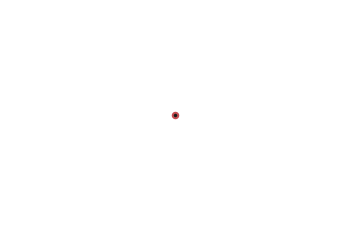

In [14]:
#use the dosage and reverse dosage metrics to color the genes

ymetric = 'OEx.corrected_mean_intensity.48'
xmetric = 'KO.corrected_mean_intensity.48'
DF = dosage_df.copy()


i_nan = (DF[xmetric+'_mean'].isna() ==0) &(DF[ymetric+'_mean'].isna() ==0)

score_max1 = DF[i_nan]['dosage'].mean()+2.5*DF[i_nan]['dosage'].std()
score_min1= DF[i_nan]['dosage'].mean()-2.5*DF[i_nan]['dosage'].std()
score_max2 = DF[i_nan]['rev_dosage'].mean()+2.5*DF[i_nan]['rev_dosage'].std()
score_min2= DF[i_nan]['rev_dosage'].mean()-2.5*DF[i_nan]['rev_dosage'].std()


dosage_raibow = [score2color2d(s1, score_max1, score_min1,
                   s2, score_max2, score_min2 ) for (s1,s2) in zip(DF[i_nan]['dosage'], DF[i_nan]['rev_dosage'])]

#plt.scatter( DF[i_nan][xmetric+'_mean'], DF[i_nan][ymetric+'_mean'], alpha=1,s=40, color=dosage_raibow, linewidth=1)
plt.axis('off')

#highligh a gene:
i_select = DF[i_nan].gene == 'SOD1'
plt.scatter( DF[i_nan][i_select][xmetric+'_mean'], DF[i_nan][i_select][ymetric+'_mean'],  alpha=1,s=30, facecolors='k', edgecolors='r',linewidth=2)


### Parse STRING database and map gene names to their systematic SGD name

In [20]:

# we use the biocat xlsx file to map gene name to SGD ORF position
Biocat=pd.read_csv('/Users/paucac/Documents/PhD/CAB/YKO_library/biocats/Yeast-Knockout-Collection-Mata.csv')
# load STRING data
columns = ['protein1', 'protein2', 'neighborhood', 'neighborhood_transferred', 'fusion' ,'cooccurence','homology' ,'coexpression', 'coexpression_transferred', 'experiments', 'experiments_transferred', 'database', 'database_transferred', 'textmining', 'textmining_transferred', 'combined_score']
String = pd.read_csv('Databases/4932.protein.links.full.v11.5.txt', sep=" ", skiprows=1,names=columns)


is_systematic = re.compile('Y[A-Z]{2}\d{3}[W|C]')

is_name = re.compile('[A-Z]+\d+|[A-Z]+\d+[A|B]') #match XXX..XX111...1 or XXX..XX111...1[A|B]

Gene_systematic = []
gene2systematic ={} #create a dict mapping current gene name to systematic name
for gene in CCM_pooled.gene:
    #determine index in biocat DF:
    if bool(is_systematic.match(gene)):
        Gene_systematic.append(gene)
        gene2systematic[gene] = gene
    elif bool(is_name.fullmatch(gene.replace(',',''))):
        i = Biocat['Gene Symbol'] == gene
        gene_systematic = Biocat.SystematicName[i].values[0]
        Gene_systematic.append(gene_systematic)
        gene2systematic[gene] = gene_systematic
    else:
        Gene_systematic.append(gene)
        gene2systematic[gene] = 'NF'
        

CCM19['systematic_gene'] = Gene_systematic

# does the same for the OEx library
SWAT=pd.read_csv('/Users/paucac/Documents/PhD/CAB/yeast libraries/Tef2_mCherry_SWAT/SWAT FG Library.csv')

#for OEx df:
Gene_systematic = []
#gene2systematic ={} #create a dict mapping current gene name to systematic name
for gene in CCM20.gene:
    #determine index in biocat DF:
    if bool(is_systematic.match(gene)):
        Gene_systematic.append(gene)
        gene2systematic[gene] = gene
    elif bool(is_name.fullmatch(gene.replace(',',''))):
        i = SWAT['Gene'] == gene
        gene_systematic = SWAT.ORF[i].values[0]
        Gene_systematic.append(gene_systematic)
        gene2systematic[gene] = gene_systematic
    else:
        Gene_systematic.append(gene)
        gene2systematic[gene] = 'NF'
CCM20['systematic_gene'] = Gene_systematic

systematic2gene={}
#create a mirror dict
for gene, systematic in gene2systematic.items():
    systematic2gene[systematic]= gene
    

### Prepare stuff for GO enrichment analsys

In [30]:
gene2entrez, entrez2gene = ge.Gene_Name_Convert(dosage_df.gene)
ns2assoc,obo = ge.Return_GOA_stuff()

# this defin the default gene group for GOEA
DF = dosage_df.copy()
population = []
for gene in DF.gene:
     if gene in gene2entrez.keys():
        population.append(int(gene2entrez[gene]))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-6018...done.
Finished.
644 input query terms found dup hits:
	[('MLP1', 2), ('ATP1', 2), ('TRP4', 2), ('YMR316C-A', 2), ('SDH1', 3), ('MSH2', 7), ('HSE1', 2), ('A
12 input query terms found no hit:
	['Blank', 'his3Δ1::SWAT-MTS', 'DUR1,2', '41548', 'Control-his3d-GF', 'his3Δ1::SWAT_/_S', 'WT', 'ADE5
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
914 ID were not found for:  ['ATP1', 'Blank', 'TRP4', 'YKR040C', 'YLR202C', 'YMR316C-A', 'HSE1', 'YGL165C', 'YGR219W', 'YNL144C', 'RHO2', 'YPR039W', 'YMR306C-A', 'YMR320W', 'TKL2', 'YDR271C', 'CCC2', 'DNF1', 'RRN5', 'YBR064W', 'YMR326C', 'YHR095W', 'YCR087W', 'YBL100C', 'COA4', 'YBR012C', 'YNL303W', 'SYM1', 'YNL277W-A', 'YAR029W', 'NOP13', 'YAR030C', 'YIL025C', 'YAL004W', 'LAP3', 'YJL007C', 'NOP58', 'YDR230W', 'YBR056W', 'YDR199W', 'DAL80'

HMS:0:00:03.961216  93,721 annotations,  6,416 genes,  5,884 GOs, 1 taxids READ: gene2go 
Databases/go.obo: fmt(1.2) rel(2021-10-26) 47,197 GO Terms; optional_attrs(relationship)


### Select groups of genes based on their Screen score 

In [31]:
## Define the gene groups we want to search
n_genes =250 #150
metric =  'corrected_mean_intensity.48_mean'
DF=CCM_pooled.copy()
gene_groups ={}

i_nan =DF[metric].isna()==0
i_sort=DF[i_nan][metric].argsort()[::-1]
gene_groups['KO_top'] = DF[i_nan].iloc[i_sort].gene.iloc[:n_genes]
gene_groups['KO_bottom'] =DF[i_nan].iloc[i_sort].gene.iloc[-n_genes:]

DF=CCM20.copy()
i_nan =DF[metric].isna()==0
i_sort=DF[i_nan][metric].argsort()[::-1]
gene_groups['OEx_top'] = DF[i_nan].iloc[i_sort].gene.iloc[:n_genes]
gene_groups['OEx_bottom'] = DF[i_nan].iloc[i_sort].gene.iloc[-n_genes:]

#create a combined dataset for all extremes
Combined= set(gene_groups['KO_top']).union(set(gene_groups['KO_bottom']))
Combined= Combined.union(set(gene_groups['OEx_top']).union(set(gene_groups['OEx_bottom'])))


#gene_groups['Combined'] =list(Combined)
#print(len(gene_groups['Combined']))
#DF=dosage_df.copy()
#metric='dosage'

#i_nan = DF[metric].isna()==0
#i_sort=np.abs(DF[metric][i_nan]).argsort()[::-1]
#gene_groups[metric] = DF[i_nan].iloc[i_sort].gene.iloc[:n_genes]

np.random.seed(0)
gene_groups['random_control'] = np.random.choice(DF[i_nan].iloc[i_sort].gene,n_genes)





### Build an example of STRING network

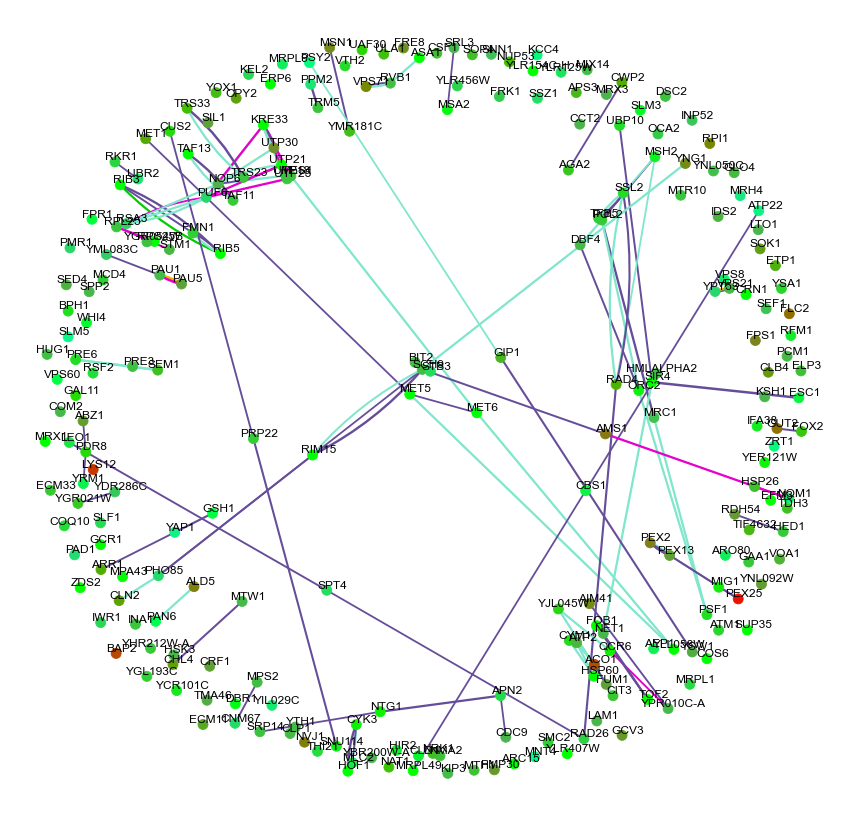

In [34]:

G= sn.build_network( gene_groups['OEx_top'],
                    gene2systematic,systematic2gene,String,
                    G= nx.MultiDiGraph(directed=False))
#pos2= nx.circular_layout(G2)
pos= nx.spring_layout(G,  seed=np.random.seed(0))
dosage = [dosage_df['dosage'][dosage_df.gene.values == node].values[0] for node in G] 
rev_dosage = [dosage_df['rev_dosage'][dosage_df.gene.values == node].values[0] for node in G] 

color_map =[score2color2d(S[0], score_max1,score_min1,S[1] , score_max2,score_min2) for S in zip(dosage,rev_dosage)]

sn.draw_network_spring( G, pos , color_map ,font_color=[0,0,0], figsize=(15,15) )

### Draw Networks, Perform clique extraction, run GO enrichment analysis within each clique to label it with signigicantly enriched GO terms

In [35]:

networks ={}
for g_name, group_select in tqdm(gene_groups.items()):

    G= sn.build_network( group_select ,
                    gene2systematic,systematic2gene,String,
                    G= nx.MultiGraph(directed=False))
    networks[g_name] = G


100%|██████████| 5/5 [00:30<00:00,  6.16s/it]


In [36]:

cliques = {}
for g_name, G in tqdm(networks.items()):
    cliques[g_name]=[]
# k clique is a community of nodes forming complete graphs which are connected to each other by at least k-1 edges
    for clique in list(nx.community.k_clique_communities(G,k=3)):
        if len(clique) >=3:
            cliques[g_name].append(list(clique))

enrichements ={} #dict storing neated listed 'KO_top':{[[genes in clique],[ enriched terms], [color]] }
for g_name, clique_group  in tqdm(cliques.items()) :
    enrichements[g_name] =[]
    for i, clique  in enumerate(clique_group) :
        clique_entrez=[]
        for gene in  clique:
            if gene in gene2entrez.keys():
                clique_entrez.append(int(gene2entrez[gene]))
        
        #print(clique_entrez)
        GEA ,go_set = ge.return_GEA(clique_entrez, population, ns2assoc, obo, p_thresh=0.05 )
        #print(clique, GEA)
        enrichment = [list(block) for block in GEA[['go','description','p']].values]
        #define a color for the clique
    
        enrichements[g_name].append([clique, enrichment])
        

  0%|          | 0/5 [00:00<?, ?it/s]


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in association

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in associatio

 20%|██        | 1/5 [00:28<01:55, 28.91s/it]


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in association

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in associatio

 40%|████      | 2/5 [01:01<01:33, 31.23s/it]


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in association

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in associatio

 60%|██████    | 3/5 [01:32<01:02, 31.22s/it]


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in association

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in associatio

 80%|████████  | 4/5 [01:59<00:29, 29.38s/it]


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in association

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88%  4,970 of  5,666 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,280 of  5,666 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,318 of  5,666 population items found in associatio

100%|██████████| 5/5 [02:23<00:00, 28.66s/it]


/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or

0 ['sulfate assimilation', 'hydrogen sulfide biosynthetic process', 'methionine biosynthetic process', 'cysteine biosynthetic process', 'cellular amino acid biosynthetic process', 'sulfate assimilation, phosphoadenylyl sulfate reduction by phosphoadenylyl-sulfate reductase (thioredoxin)', 'siroheme biosynthetic process', 'sulfur amino acid metabolic process', 'porphyrin-containing compound biosynthetic process']
['HIS3', 'MET17', 'MET8', 'MET10', 'MET1', 'MET3', 'MET14', 'MET28', 'ADE2', 'MET16']
1 ['Swr1 complex', 'chromatin remodeling', 'chromatin organization', 'histone binding']
['SWC7', 'VPS71', 'YAF9', 'VPS72', 'SWR1']
2 ['cellular response to DNA damage stimulus', 'single-stranded DNA binding', 'DNA binding', 'nuclear replication fork', 'DNA helicase activity']
['RMI1', 'RAD51', 'SRS2', 'RRM3']
3 ['mitochondrial pyruvate dehydrogenase complex', 'mitochondrial nucleoid']
['AIM22', 'PDA1', 'LPD1']
4 ['fatty acid biosynthetic process', 'fatty acid metabolic process']
['HTD2', 'HFA1

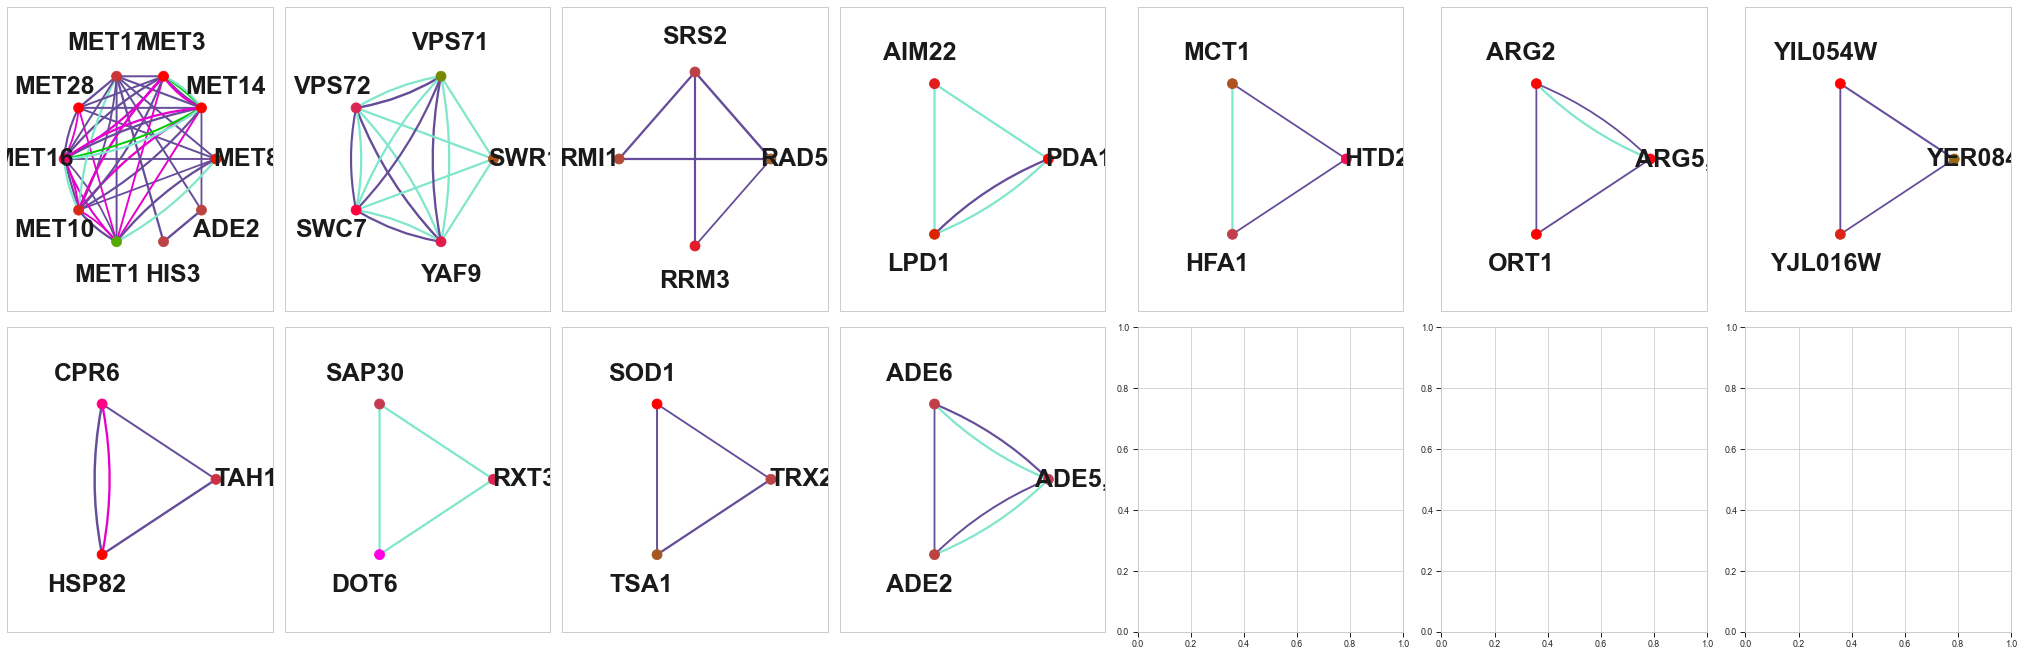

0 ['ribosome', 'structural constituent of ribosome', 'ribonucleoprotein complex', 'cytoplasmic translation', 'translation', 'cytosolic small ribosomal subunit', 'cytosolic large ribosomal subunit', '90S preribosome', 'RNA binding', 'cytoplasm', 'small ribosomal subunit', 'rRNA binding']
['RPS9B', 'RPL24A', 'RPS4B', 'LOC1', 'RPL21A', 'RPL19B', 'RPS0B', 'RPS16A', 'RPL12B', 'RPS4A', 'RPP2B', 'RPL31A', 'RPS18A', 'ASC1', 'RPS6B', 'RPL19A', 'BUD22']
1 ['ATP export', 'endosome', 'endosome membrane', 'vacuolar transport', 'late endosome to vacuole transport', 'intralumenal vesicle formation', 'multivesicular body', 'protein transport', 'ESCRT III complex', 'endosome transport via multivesicular body sorting pathway', 'protein transport to vacuole involved in ubiquitin-dependent protein catabolic process via the multivesicular body sorting pathway', 'late endosome to vacuole transport via multivesicular body sorting pathway', 'protein targeting to vacuole', 'ubiquitin-dependent protein cataboli

KeyboardInterrupt: 

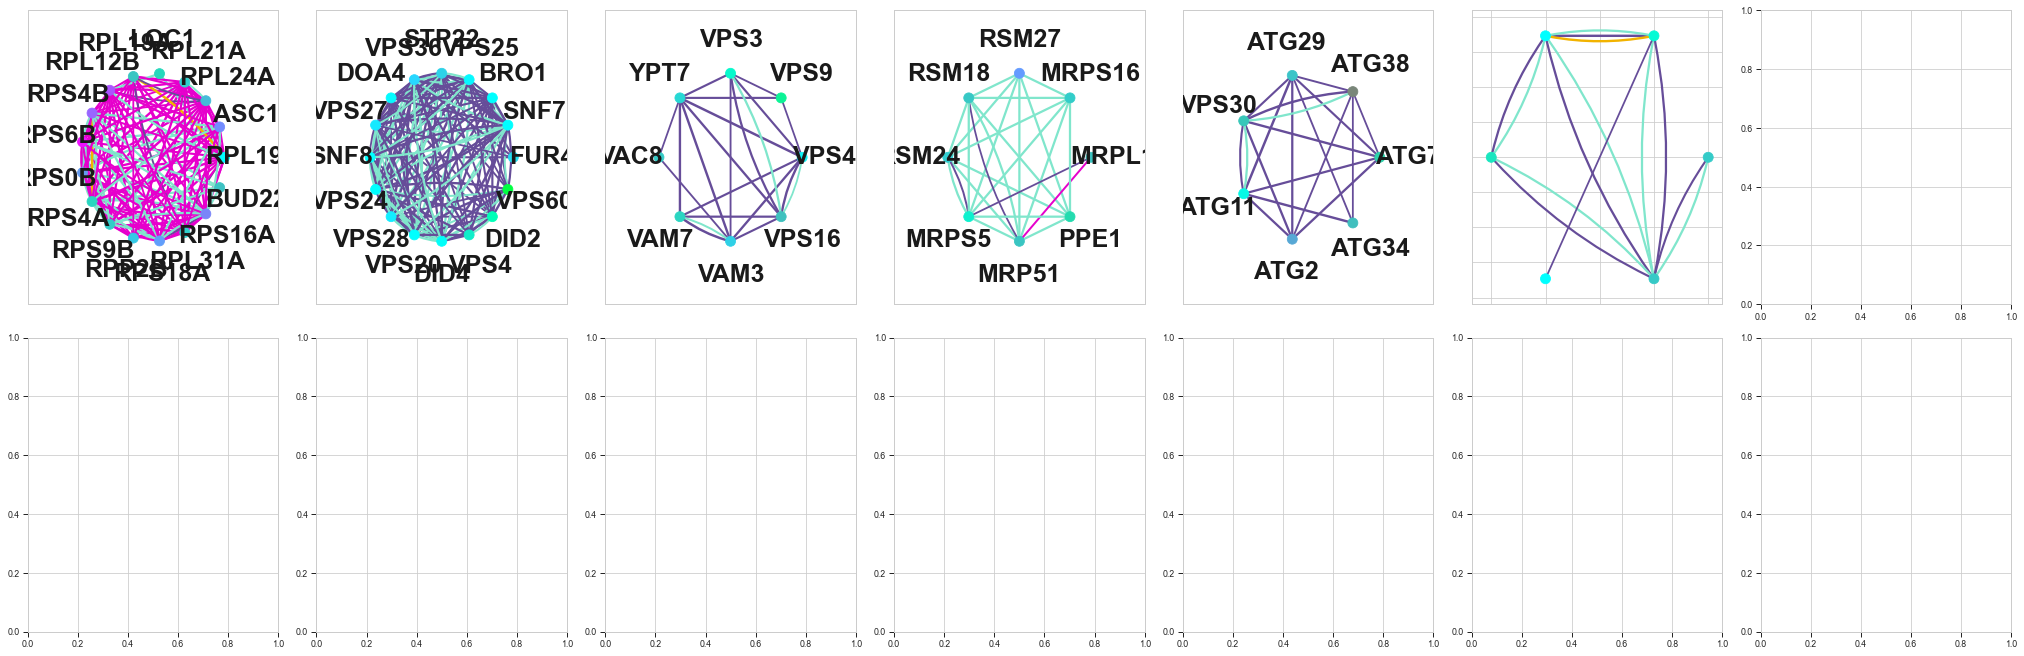

In [37]:
#draw clique networks by order of size

P=[] #store p-values of enrichemnts
Y=[] #size of clique
L=[] #label
G= [] #genes
GO =[]
for g_name, group_select in gene_groups.items():

    p=[]
    y=[]
    g=[]
    go=[]
    for [group_select, GOs] in  enrichements[g_name]:
        p.append([GO[2] for GO in GOs]) 
        go.append([GO[1] for GO in GOs])
        y.append(len(group_select))
        g.append(group_select)
        

            
    Y.append(y)
    P.append(p)
    L.append(g_name)
    G.append(g)
    GO.append(go)
        
# P >> the container for all gene group
# p >> the container for each gene group
# p_ >> the container for p values of individual cliques


for i,(p,y,l,g,go) in enumerate(zip(P,Y, L,G, GO)):

    fig, ax= plt.subplots(2,7,figsize=(28,9), constrained_layout=True)
    ax=ax[:].flatten()
    i_size_sort = list(np.argsort(y)[::-1] )#sort based on the number of genes in clique  
    #sort y and p
    p = np.array(p)[i_size_sort]
    g = np.array(g)[i_size_sort]
    go = np.array(go)[i_size_sort]
    ii=0
    for group_select in g:
        G= sn.build_network( group_select ,
                    gene2systematic,systematic2gene,String,
                    G= nx.MultiDiGraph(directed=False))

        pos= nx.spring_layout(G,  seed=np.random.seed(0))
        pos= nx.circular_layout(G)

       # pos = {}
       # for gene in G.nodes():
        #    x= DF[xmetric+'_mean'][DF.gene==gene].values
        #    x = 0 if np.isnan(x) else x
        #    y= DF[ymetric+'_mean'][DF.gene==gene].values
        #    y = 0 if np.isnan(y) else y
        #    pos[gene] = np.array([x,y]).squeeze().astype(float)
        dosage = [dosage_df['dosage'][dosage_df.gene.values == node].values[0] for node in G] 
        rev_dosage = [dosage_df['rev_dosage'][dosage_df.gene.values == node].values[0] for node in G] 
#
        color_map =[score2color2d(S[0], score_max1,score_min1,S[1] , score_max2,score_min2) for S in zip(dosage,rev_dosage)]
        fig,ax[ii] = sn.draw_tonsof_network( G, pos , color_map , fig,ax[ii], font_color=[0,0,0])
        shift=1.4
        
        label_pos = {node:(x*shift,y*shift) for i, (node, (x,y)) in zip(range(len(pos)),pos.items())}
        nx.draw_networkx_labels(G, pos=label_pos, ax=ax[ii],font_color = 'k',font_weight='bold',font_size=25 )

        #ax[ii].set_title(go[ii][0], fontsize=15,fontweight='bold')
        print(ii, go[ii])
        print(group_select)
        ax[ii].set_ylim([-1.75,1.75])
        ax[ii].set_xlim([-1.75,1.75])
        ax[ii].grid(b=None)
        #ax[ii].axis('off')
        #ax[ii].set_title('Clique '+ str(ii+1), fontsize=15,fontweight='bold')
        ii+=1
  
    plt.show()

<module 'String_Networks' from '/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/Colony_Analysis/Published_Code/CRI-SPA_CCM/String_Networks.py'>

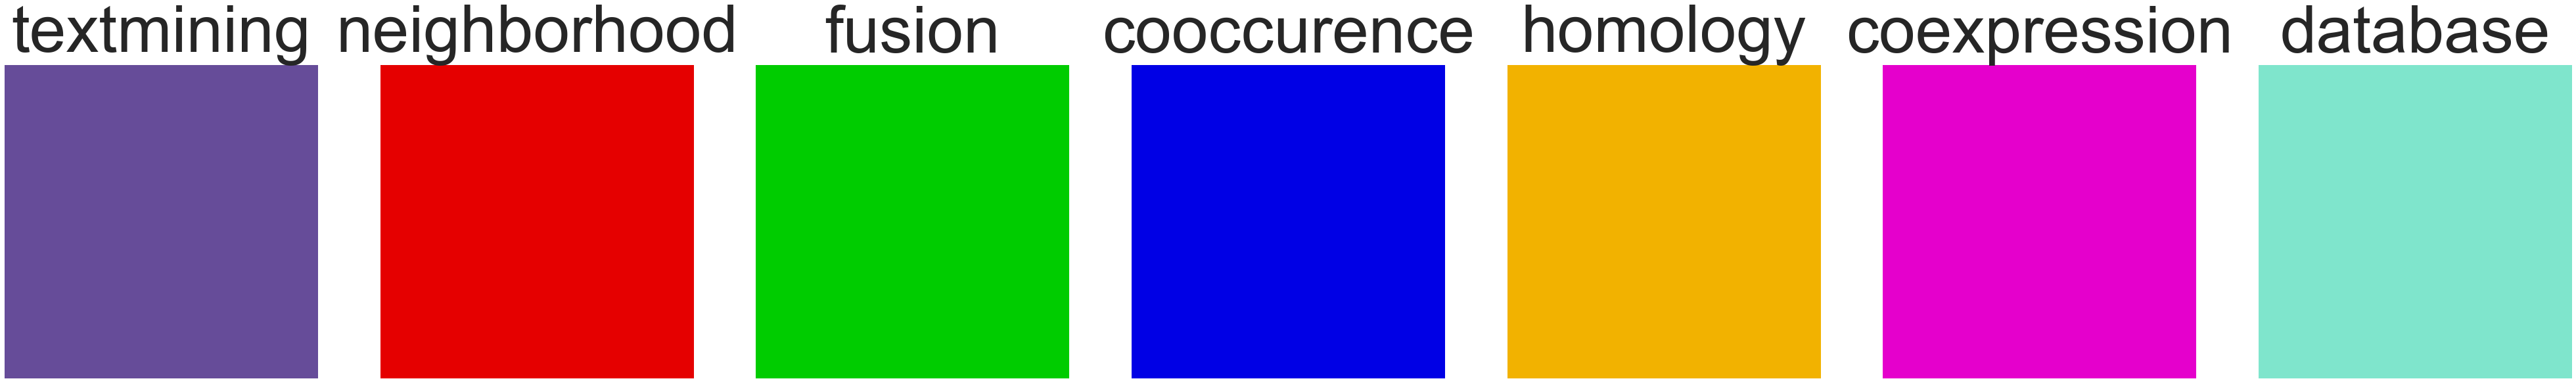

In [47]:
importlib.reload(sn)

/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or

0 ['nucleolus', '90S preribosome', 'ribosome biogenesis', 'ribosomal small subunit biogenesis', 'rRNA processing', 'ribonucleoprotein complex', 'Pwp2p-containing subcomplex of 90S preribosome', 'small-subunit processome', 'preribosome, large subunit precursor', 'rRNA binding']
['NOP6', 'UTP18', 'RPL25', 'PUF6', 'RSA3', 'UTP21', 'UTP30', 'UTP25', 'KRE33']


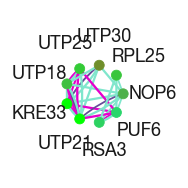

1 ['tricarboxylic acid cycle', 'mitochondrial matrix']
['ACO1', 'CIT3', 'FUM1']


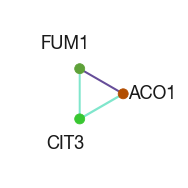

2 ['rDNA heterochromatin assembly', 'nucleolus organization', 'negative regulation of septation initiation signaling', 'protein localization to nucleolar rDNA repeats', 'phosphatase activator activity', 'rDNA binding', 'rDNA condensation']
['TOF2', 'FOB1', 'NET1']


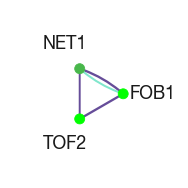

3 ['protein serine/threonine kinase activity', 'protein kinase activity', 'kinase activity', 'protein phosphorylation']
['RIM15', 'SCH9', 'PHO85']


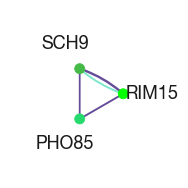

4 ['nucleotide-excision repair', 'mismatch repair', 'DNA repair', 'cellular response to DNA damage stimulus']
['RAD4', 'MSH2', 'SSL2']


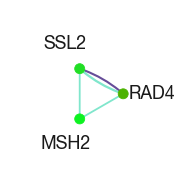

5 ['mitochondrial nucleoid']
['ACO1', 'ATP2', 'HSP60']


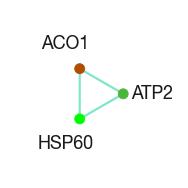

6 ['riboflavin biosynthetic process']
['FMN1', 'RIB5', 'RIB3']


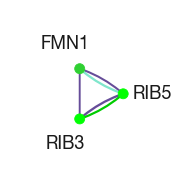

7 ['proteasome storage granule', 'proteasome complex', 'proteasome core complex', 'proteasome-mediated ubiquitin-dependent protein catabolic process', 'proteasomal protein catabolic process', 'proteasomal ubiquitin-independent protein catabolic process', 'proteolysis involved in cellular protein catabolic process']
['PRE6', 'PRE3', 'SEM1']


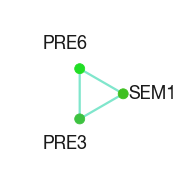

8 ['cellular bud neck contractile ring', 'HICS complex', 'myosin II heavy chain binding', 'cellular bud neck', 'mitotic cytokinesis', 'cell division']
['MLC2', 'HOF1', 'CYK3']


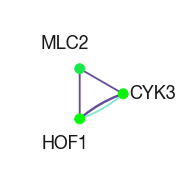

9 ['DNA replication', 'mitotic DNA replication checkpoint signaling']
['POL2', 'DBF4', 'ORC2']


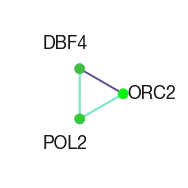

10 ['peroxisomal membrane', 'peroxisomal importomer complex', 'peroxisome']
['PEX25', 'PEX13', 'PEX2']


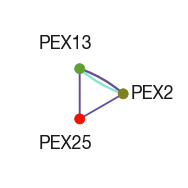

11 []
['MET5', 'MET6', 'YLL058W']


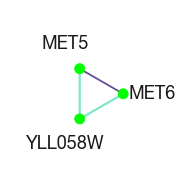

In [91]:
#draw clique networks by order of size

P=[] #store p-values of enrichemnts
Y=[] #size of clique
L=[] #label
G= [] #genes
GO =[]
g_name = 'OEx_top'
group_select = gene_groups[g_name]


p=[]
y=[]
g=[]
go=[]
for [group_select, GOs] in  enrichements[g_name]:
    p.append([GO[2] for GO in GOs]) 
    go.append([GO[1] for GO in GOs])
    y.append(len(group_select))
    g.append(group_select)



Y.append(y)
P.append(p)
L.append(g_name)
G.append(g)
GO.append(go)
        
# P >> the container for all gene group
# p >> the container for each gene group
# p_ >> the container for p values of individual cliques


for i,(p,y,l,g,go) in enumerate(zip(P,Y, L,G, GO)):

   

    i_size_sort = list(np.argsort(y)[::-1] )#sort based on the number of genes in clique  
    #sort y and p
    p = np.array(p)[i_size_sort]
    g = np.array(g)[i_size_sort]
    go = np.array(go)[i_size_sort]
    ii=0
    for group_select in g:
        G= sn.build_network( group_select ,
                    gene2systematic,systematic2gene,String,
                    G= nx.MultiDiGraph(directed=False))

        pos= nx.spring_layout(G,  seed=np.random.seed(0))
        pos= nx.circular_layout(G)

       # pos = {}
       # for gene in G.nodes():
        #    x= DF[xmetric+'_mean'][DF.gene==gene].values
        #    x = 0 if np.isnan(x) else x
        #    y= DF[ymetric+'_mean'][DF.gene==gene].values
        #    y = 0 if np.isnan(y) else y
        #    pos[gene] = np.array([x,y]).squeeze().astype(float)
        dosage = [dosage_df['dosage'][dosage_df.gene.values == node].values[0] for node in G] 
        rev_dosage = [dosage_df['rev_dosage'][dosage_df.gene.values == node].values[0] for node in G] 
#
        color_map =[score2color2d(S[0], score_max1,score_min1,S[1] , score_max2,score_min2) for S in zip(dosage,rev_dosage)]
        
        fig, ax= plt.subplots(figsize=(2.5,2.5), constrained_layout=True)
        fig,ax = sn.draw_tonsof_network( G, pos , color_map , fig,ax, font_color=[0,0,0], node_size=100)
        shift=2
        

        label_pos = {node:(x*shift,y*shift) for i, (node, (x,y)) in zip(range(len(pos)),pos.items())}
        nx.draw_networkx_labels(G, pos=label_pos, ax=ax,font_color = 'k',font_size=18,font_family = 'helvetica neue' )#font_weight='bold'

        #ax[ii].set_title(go[ii][0], fontsize=15,fontweight='bold')
        print(ii, go[ii])
        print(group_select)
        ax.set_ylim([-3,3])
        ax.set_xlim([-3,3])
        ax.grid(b=None)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        plt.show()
        
        #ax[ii].axis('off')
        #ax[ii].set_title('Clique '+ str(ii+1), fontsize=15,fontweight='bold')
        ii+=1
  
    